<center>
<h2>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h2>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2020</h3>
<h3>Predicción de la Calidad de Servicio</h3>
<h3>Análisis y Curación</h3>
</center>
</left>
<h4>Mentor: Martín Hunziker</h4>

[Link Mentoria](https://sites.google.com/view/mentorias2020-diplodatos/ciencia-de-datos-aplicada-en-la-distribuci%C3%B3n-de-energ%C3%ADa-el%C3%A9ctrica?authuser=0).

</left>
</left>

#Grupo 2
###Marcelo Tisera
###Laura Aliendo
###Joel de Andres

### Introducción

En la siguiente notebook, se presentará la consigna a seguir para el segundo práctico de la materia Análisis y Curación. El objetivo consiste en vincular las tablas del dataset, así como iniciar el tratamiento de los datos geográficos.

Como referencia para el análisis geográfico utilizaremos la notebook 2_0_Intro_Variables_georefrenciadas de Ramiro Caro.


In [ ]:
# Instalación de librerias en Collab
!pip install geopandas
!apt install libspatialindex-dev
!pip install rtree
!pip install osmnx
!pip install contextily

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
# En Collab
!wget -nc https://github.com/mahunz/Diplodatos2020/blob/master/Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z?raw=true
!apt-get install p7zip
!mkdir -p Dataset
!mv ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z?raw=true ./Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z
!7za x ./Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z
!mv ENF_6612_2018-12-31_M10_20190529-1610.gdb ./Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb

--2020-09-04 20:23:43--  https://github.com/mahunz/Diplodatos2020/blob/master/Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mahunz/Diplodatos2020/raw/master/Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z [following]
--2020-09-04 20:23:43--  https://github.com/mahunz/Diplodatos2020/raw/master/Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mahunz/Diplodatos2020/master/Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z [following]
--2020-09-04 20:23:43--  https://raw.githubusercontent.com/mahunz/Diplodatos2020/master/Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z
Resolving raw.githubusercontent.com (raw.githubuserco

In [ ]:
# En Collab
!mkdir -p DatasetOrigin
!cp -i -r ./Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb ./DatasetOrigin/ENF_6612_2018-12-31_M10_20190529-1610_origin.gdb

### I. Rutina de Curación

Inicialmente, con el objetivo de preparar los datos que alimentarán futuros modelos de aprendizaje automático (ML), se propone seguir la siguiente __[checklist](https://dimewiki.worldbank.org/wiki/Checklist:_Data_Cleaning)__ para la limpieza de los datos de nuestro proyecto. Esta _checklist_ es la misma que utilizaron en el primer práctico de la materia y nos será de utilidad como guía para curar el dataset. A modo de ayuda, **en esta notebook encontrarán una especie de template** que sigue la _checklist_ y que deberán ir completando.

**Cada decisión tomada deberá quedar registrada de manera explícita y clara.** Luego de pasar por todos los puntos de la _checklist_ propuesta, deberán almacenar en un nuevo archivo los datos resultantes.


### II. Análisis del Contenido

Una vez aplicado el  _Checklist_, lo que vamos a hacer es comenzar a vincular las diferentes tablas del dataset e iniciar la generación de features geográficas


# Resolución

## I. Rutina de Curación

### 1. Importación de Datos

#### 1.1. Verificación de Inexistencia de Problemas en la Importación

A partir de este punto, utilizaremos los transformadores de distribucion como elemnto de analisis tabla UNTRD, e incorporaremos datos de consumidores, subestación y líneas de distribución.

Para comenzar, importamos los datos que vamos a procesar de las diferentes tablas que vamos a analizar:

In [149]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString
import numpy as np
import osmnx as ox
import scipy as sc
from sklearn import preprocessing
from shapely.ops import nearest_points
from scipy.spatial import cKDTree

In [ ]:
# Editar con el path correspondiente a sus datos
data_path = './Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb'
data_path_origin = './Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb'

print(data_path)
print(data_path_origin)
 

./Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb
./Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb


In [ ]:
datasets = {}

In [ ]:
conj = gpd.read_file(data_path, driver='FileGDB', layer='CONJ')
datasets['conj'] = conj
datasets['conj']['COD_ID'] = datasets['conj']['COD_ID'].astype(int)
conj = datasets['conj']
conj.shape, conj.columns 

((5, 9), Index(['COD_ID', 'DIST', 'NOM', 'SIST_INTE', 'SIST_SUBT', 'DESCR',
        'Shape_Length', 'Shape_Area', 'geometry'],
       dtype='object'))

In [ ]:
untrd = gpd.read_file(data_path, driver='FileGDB', layer='UNTRD')
untrd['CONJ'] = untrd['CONJ'].astype(int)
untrd.shape, untrd.columns

((3879, 33),
 Index(['COD_ID', 'DIST', 'PAC_1', 'PAC_2', 'PAC_3', 'FAS_CON_P', 'FAS_CON_S',
        'FAS_CON_T', 'SIT_ATIV', 'TIP_UNID', 'POS', 'ATRB_PER', 'TEN_LIN_SE',
        'CAP_ELO', 'CAP_CHA', 'TAP', 'CONF', 'POSTO', 'POT_NOM', 'PER_FER',
        'PER_TOT', 'DAT_CON', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ', 'MUN', 'BANC',
        'TIP_TRAFO', 'MRT', 'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

In [ ]:
untrs = gpd.read_file(data_path, driver='FileGDB', layer='UNTRS')
untrs['CONJ'] = untrs['CONJ'].astype(int)
untrs.shape, untrs.columns

((6, 53),
 Index(['COD_ID', 'SUB', 'BARR_1', 'BARR_2', 'BARR_3', 'PAC_1', 'PAC_2',
        'PAC_3', 'DIST', 'FAS_CON_P', 'FAS_CON_S', 'FAS_CON_T', 'SIT_ATIV',
        'TIP_UNID', 'POS', 'POT_NOM', 'POT_F01', 'POT_F02', 'PER_FER',
        'PER_TOT', 'BANC', 'DAT_CON', 'CONJ', 'MUN', 'TIP_TRAFO', 'ALOC_PERD',
        'ENES_01', 'ENES_02', 'ENES_03', 'ENES_04', 'ENES_05', 'ENES_06',
        'ENES_07', 'ENES_08', 'ENES_09', 'ENES_10', 'ENES_11', 'ENES_12',
        'ENET_01', 'ENET_02', 'ENET_03', 'ENET_04', 'ENET_05', 'ENET_06',
        'ENET_07', 'ENET_08', 'ENET_09', 'ENET_10', 'ENET_11', 'ENET_12',
        'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

In [ ]:
ssmt = gpd.read_file(data_path, driver='FileGDB', layer='SSDMT')
ssmt['CONJ'] = ssmt['CONJ'].astype(int)
ssmt.shape, ssmt.columns

((24929, 24),
 Index(['COD_ID', 'PN_CON_1', 'PN_CON_2', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ',
        'DIST', 'PAC_1', 'PAC_2', 'FAS_CON', 'TIP_CND', 'POS', 'ODI_FAS',
        'TI_FAS', 'ODI_NEU', 'TI_NEU', 'COMP', 'DESCR', 'SITCONTFAS',
        'SITCONTNEU', 'ARE_LOC', 'Shape_Length', 'geometry'],
       dtype='object'))

In [ ]:
segcon = gpd.read_file(data_path, driver='FileGDB', layer='SEGCON')
segcon.shape, segcon.columns

((90, 40),
 Index(['COD_ID', 'DIST', 'GEOM_CAB', 'FORM_CAB', 'MAT_FAS_1', 'MAT_FAS_2',
        'MAT_FAS_3', 'MAT_NEU', 'ISO_FAS_1', 'ISO_FAS_2', 'ISO_FAS_3',
        'ISO_NEU', 'CND_FAS', 'R1', 'X1', 'FTRCNV', 'CNOM', 'CMAX', 'CM_FAS',
        'TUC_FAS', 'A1_FAS', 'A2_FAS', 'A3_FAS', 'A4_FAS', 'A5_FAS', 'A6_FAS',
        'CM_NEU', 'TUC_NEU', 'A1_NEU', 'A2_NEU', 'A3_NEU', 'A4_NEU', 'A5_NEU',
        'A6_NEU', 'DESCR', 'BIT_FAS_1', 'BIT_FAS_2', 'BIT_FAS_3', 'BIT_NEU',
        'geometry'],
       dtype='object'))

In [ ]:
ucbt = gpd.read_file(data_path, driver='FileGDB', layer='UCBT')
ucbt['CONJ'] = ucbt['CONJ'].astype(int)
ucbt.shape, ucbt.columns

((108346, 40),
 Index(['DIST', 'PAC', 'PN_CON', 'UNI_TR_D', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ',
        'MUN', 'BRR', 'CEP', 'CLAS_SUB', 'CNAE', 'TIP_CC', 'FAS_CON', 'GRU_TEN',
        'TEN_FORN', 'GRU_TAR', 'SIT_ATIV', 'DAT_CON', 'CAR_INST', 'LIV',
        'ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07',
        'ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12', 'DIC', 'FIC',
        'SEMRED', 'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

In [ ]:
ucbt_cod_id = ucbt.reset_index()
ucbt_cod_id['COD_ID'] = ucbt_cod_id.index

In [ ]:
# Agrupando Variables

ucbt['ENE_MED'] = ucbt[['ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07','ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12']].mean(axis=1)
ucbt['ENE_STD'] = ucbt[['ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07','ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12']].std(axis=1)
ucbt['ENE_MAX'] = ucbt[['ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07','ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12']].max(axis=1)


ucbt_cod_id['ENE_MED'] = ucbt_cod_id[['ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07','ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12']].mean(axis=1)
ucbt_cod_id['ENE_STD'] = ucbt_cod_id[['ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07','ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12']].std(axis=1)
ucbt_cod_id['ENE_MAX'] = ucbt_cod_id[['ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07','ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12']].max(axis=1)

### 1.2. Asegurar la Existencia de IDs o Claves Únicas

In [ ]:
print(untrd['COD_ID'].is_unique)
print(untrs['COD_ID'].is_unique)
print(ssmt['COD_ID'].is_unique)
print(segcon['COD_ID'].is_unique)

True
True
True
True


El siguiente paso implica chequear que no existen datos duplicados y que las claves, si existen, son únicas.

Las claves únicas de las diferentes tablas es el COD_ID, como figura en la documentación. En el caso de la tabla UCBT fue eliminado por el proveedor de los datos por lo que asumiremos que los datos son únicos. Podriamos regenerar el COD_ID con un valor secuencial, pero como vamos a utilizar la tabla UNTRD como elementos de análisis no será necesario

In [ ]:
cod_id = 'COD_ID'
untrd_duplicado_cod_id  = untrd[untrd[cod_id].duplicated(keep=False)]
untrd_duplicado_cod_id

,COD_ID,DIST,PAC_1,PAC_2,PAC_3,FAS_CON_P,FAS_CON_S,FAS_CON_T,SIT_ATIV,TIP_UNID,POS,ATRB_PER,TEN_LIN_SE,CAP_ELO,CAP_CHA,TAP,CONF,POSTO,POT_NOM,PER_FER,PER_TOT,DAT_CON,CTMT,UNI_TR_S,SUB,CONJ,MUN,BANC,TIP_TRAFO,MRT,DESCR,ARE_LOC,geometry


In [ ]:
untrs_duplicado_cod_id  = untrs[untrs[cod_id].duplicated(keep=False)]
untrs_duplicado_cod_id

,COD_ID,SUB,BARR_1,BARR_2,BARR_3,PAC_1,PAC_2,PAC_3,DIST,FAS_CON_P,FAS_CON_S,FAS_CON_T,SIT_ATIV,TIP_UNID,POS,POT_NOM,POT_F01,POT_F02,PER_FER,PER_TOT,BANC,DAT_CON,CONJ,MUN,TIP_TRAFO,ALOC_PERD,ENES_01,ENES_02,ENES_03,ENES_04,ENES_05,ENES_06,ENES_07,ENES_08,ENES_09,ENES_10,ENES_11,ENES_12,ENET_01,ENET_02,ENET_03,ENET_04,ENET_05,ENET_06,ENET_07,ENET_08,ENET_09,ENET_10,ENET_11,ENET_12,DESCR,ARE_LOC,geometry


In [ ]:
ssmt_duplicado_cod_id  = ssmt[ssmt[cod_id].duplicated(keep=False)]
ssmt_duplicado_cod_id

,COD_ID,PN_CON_1,PN_CON_2,CTMT,UNI_TR_S,SUB,CONJ,DIST,PAC_1,PAC_2,FAS_CON,TIP_CND,POS,ODI_FAS,TI_FAS,ODI_NEU,TI_NEU,COMP,DESCR,SITCONTFAS,SITCONTNEU,ARE_LOC,Shape_Length,geometry


In [ ]:
segcon_duplicado_cod_id  = segcon[segcon[cod_id].duplicated(keep=False)]
segcon_duplicado_cod_id

,COD_ID,DIST,GEOM_CAB,FORM_CAB,MAT_FAS_1,MAT_FAS_2,MAT_FAS_3,MAT_NEU,ISO_FAS_1,ISO_FAS_2,ISO_FAS_3,ISO_NEU,CND_FAS,R1,X1,FTRCNV,CNOM,CMAX,CM_FAS,TUC_FAS,A1_FAS,A2_FAS,A3_FAS,A4_FAS,A5_FAS,A6_FAS,CM_NEU,TUC_NEU,A1_NEU,A2_NEU,A3_NEU,A4_NEU,A5_NEU,A6_NEU,DESCR,BIT_FAS_1,BIT_FAS_2,BIT_FAS_3,BIT_NEU,geometry


In [ ]:
ucbt_duplicado_cod_id  = ucbt_cod_id[ucbt_cod_id[cod_id].duplicated(keep=False)]
ucbt_duplicado_cod_id

,index,DIST,PAC,PN_CON,UNI_TR_D,CTMT,UNI_TR_S,SUB,CONJ,MUN,BRR,CEP,CLAS_SUB,CNAE,TIP_CC,FAS_CON,GRU_TEN,TEN_FORN,GRU_TAR,SIT_ATIV,DAT_CON,CAR_INST,LIV,ENE_01,ENE_02,ENE_03,ENE_04,ENE_05,ENE_06,ENE_07,ENE_08,ENE_09,ENE_10,ENE_11,ENE_12,DIC,FIC,SEMRED,DESCR,ARE_LOC,geometry,COD_ID,ENE_MED,ENE_STD,ENE_MAX


In [ ]:
conj_duplicado_cod_id  = conj[conj[cod_id].duplicated(keep=False)]
conj_duplicado_cod_id

,COD_ID,DIST,NOM,SIST_INTE,SIST_SUBT,DESCR,Shape_Length,Shape_Area,geometry


### 1.3. Despersonalizar Datos y Guardarlos en un Nuevo Archivo

En este caso, no es necesario despersonalizar ningún dato, dado que los mismos ya se encuentran despersonalizados.

### 1.4. Nunca Modificar los Datos Crudos u Originales

Al finalizar la limpieza, deberán guardar el dataset resultante, para asegurarse de no modificar los datos originales.

Creamos 2 dataset para evitar modificar el original 1 con el nombre de que esta en un dir DatasetOrigin/data_path_origin.

El que usaremos para modificar que es el data_path en el dir Dataset/

## 2. Pasos de Limpieza Necesarios

### 2.1. Etiquetas de Variables/Columnas y Problemas de Codificación/Encoding

El geopandas automáticamente detecta el encoding de los datos. 

### 2.2. Tratamiento de Valores Faltantes

Para analizar los valores faltantes, primero deberán saber cuántos existen por campo y cuánto representan del total:

In [ ]:
# get the number of missing data points per column
list_dataset = [{"name":"UNTRD","data_set":untrd},
{"name":"UNTRS","data_set":untrs},
{"name":"SSMT","data_set":ssmt}, 
{"name":"SEGCON","data_set":segcon}, 
{"name":"UCBT","data_set":ucbt_cod_id}, 
{"name":"CONJ","data_set":conj}]

for dataset in list_dataset:
  missing_value = dataset.get("data_set").isnull().sum()
  count_value = dataset.get("data_set").COD_ID.count()
  print("\nValores null de {} : {}".format(dataset.get("name"),missing_value[missing_value > 0]))
  if len( missing_value[missing_value > 0]) > 0 :
    for i in missing_value[missing_value > 0]:
      print("Cantidad de registros  : {}".format(count_value))
      print("Cantidad de registros Null : {}".format(i))
      print("Representa el % : {}".format((i*100)/count_value))
  else:
    print("No tiene valores Nulls")




Valores null de UNTRD : Series([], dtype: int64)
No tiene valores Nulls

Valores null de UNTRS : Series([], dtype: int64)
No tiene valores Nulls

Valores null de SSMT : Series([], dtype: int64)
No tiene valores Nulls

Valores null de SEGCON : geometry    90
dtype: int64
Cantidad de registros  : 90
Cantidad de registros Null : 90
Representa el % : 100.0

Valores null de UCBT : Series([], dtype: int64)
No tiene valores Nulls

Valores null de CONJ : Series([], dtype: int64)
No tiene valores Nulls


En la tabla de SEGCON existen valores null en el campo geometry en la totalidad de los registros.

### 2.3. Codificación de Variables Categóricas

Aplica?

In [ ]:
datasets = {'untrd': untrd, 'ucbt': ucbt}
columns_to_encode = ['ARE_LOC', 'GRU_TAR']

for key, dataset in datasets.items():
    for column in columns_to_encode:
        if column in dataset:
            le = preprocessing.LabelEncoder()
            le.fit(dataset[column])
            dataset[column] = le.transform(dataset[column])

### 2.4. No Cambiar los Nombres de las Variables de la Fuente de Origen

### 2.5. Verificación de Consistencia de Datos

Este es el paso más analítico, en donde se deben aplicar reglas de integridad.

Si se eliminana lo valores NaN que pasa con los registros de segcon? 

In [ ]:
untrd = untrd.dropna()
untrs = untrs.dropna()
ssmt = ssmt.dropna()
#segcon = segcon.dropna()
ucbt = ucbt.dropna()
conj = conj.dropna()

### 2.6. Identificar y Documentar Valores Atípicos/Outliers

Calcular estadísticos.

In [ ]:
def find_outliers(dataset, column_name):
    interesting_col = dataset[column_name]
    CI =  (interesting_col.quantile(0.75)-interesting_col.quantile(0.25))
    mask_outlier = (
        np.abs(interesting_col - interesting_col.median()) >= (1.5 * CI))
    return dataset[mask_outlier]


main_statisticians = ['FIC', 'DIC', 'ENE_MED']

outliers = []
for key, dataset in datasets.items():
    print("Dataset: ", key)
    for column in main_statisticians:
        if column in dataset:
            outliers = find_outliers(dataset, column)
            row_quantity = dataset.shape[0]
            print("Cantidad de outliers para la variable ", column, len(outliers))
    print("------------------------------------------------")

Dataset:  untrd
------------------------------------------------
Dataset:  ucbt
Cantidad de outliers para la variable  FIC 12360
Cantidad de outliers para la variable  DIC 15122
Cantidad de outliers para la variable  ENE_MED 8363
------------------------------------------------


In [ ]:
# Procedemos a limpiar los outliers para la layer ucbt
def clean_outliers(dataset, column_name):
    interesting_col = dataset[column_name]
    CI =  (interesting_col.quantile(0.75)-interesting_col.quantile(0.25))
    mask_outlier = (
        np.abs(interesting_col - interesting_col.median()) <= (1.5 * CI))
    return dataset[mask_outlier]


for column in main_statisticians:
    ucbt_without_outliers = clean_outliers(ucbt, column)
datasets['ucbt'] = ucbt_without_outliers


### 2.7. Evaluar Cómo Comprimir los Datos Para su Almacenamiento Más Eficiente

### 2.8. Guardar el Set de Datos con un Nombre Informativo

## 3. Pasos de Limpieza Deseables

### 3.1. Ordenar Variables/Columnas

### 3.2. Quitar Variables/Columnas Irrelevantes

Tenemos alguna en este caso?

In [ ]:
datasets['ucbt'].drop(datasets['ucbt'].columns.difference(['GRU_TAR', 'UNI_TR_D', 'UNI_TR_S', 'DIC', 'FIC', 'ENE_MED', 'ENE_MAX']), 1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
datasets['untrd'].drop(datasets['untrd'].columns.difference(['COD_ID', 'UNI_TR_S', 'ARE_LOC', 'geometry']), 1, inplace=True)

### 3.3. Renombrar Variables de Grillas

### 3.4. Categorizar Variables que Contengan “Otros”

### 3.5. Agregar Metadata a los Datos

Cuando y como fueron obtenidos, limpieza realizada, decisiones implementadas, asunciones, etc.

## II. Análisis  Contenido

### 1. Features Tipo Objetos

In [ ]:
datasets['ucbt'] = datasets['ucbt'].groupby(['UNI_TR_D']).agg(GRU_TAR=('GRU_TAR',lambda x: sc.stats.mode(x)[0]),
                                                              DIC=('DIC',np.sum),FIC=('FIC',np.sum),ENE_MED=('ENE_MED',np.mean),
                                                              ENE_MAX=('ENE_MAX',np.sum)).reset_index()
datasets['ucbt']

,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX
0,,1,36.66,10.0,29.750000,2890.0
1,101415715,1,76.55,28.0,97.791667,372.0
2,102321736,1,17.18,7.0,1.000000,5.0
3,103455355,1,8.31,7.0,91.333333,116.0
4,105138826,1,16.10,12.0,13.583333,35.0
...,...,...,...,...,...,...
3331,92651766,1,14.10,6.0,2.300000,57.0
3332,96872663,1,63.58,20.0,8.083333,30.0
3333,96997174,1,59.51,18.0,36.916667,49.0
3334,97134637,1,20.91,11.0,112.416667,221.0


GRU_TAR: tomamos su moda
<br>
DIC: calculamos su suma
<br>
FIC: calculamos su suma
<br>
ARE_LOC: tomamos su moda
<br>
ENE_MED: calculamos su promedio
<br>
ENE_MAX: calculamos su suma

## Consumindores

1 - A partir de los resultados obtenidos en el práctico 1 seleccione que features podrían ser relevantes para la predicción de la calidad de servicio.

2 - Agrupe los datos en base a la variable UNI_TR_D.

3 - Justifique los métodos utilizados para agrupar las variables numéricas y categóricas.

In [ ]:
#med_group = ucbt.groupby("UNI_TR_D").agg({"DIC":"mean", "FIC":"mean"})
ucbt_group = ucbt.groupby("UNI_TR_D").agg(GRU_TAR=('GRU_TAR',lambda x: sc.stats.mode(x)[0]),
                                                              DIC=('DIC',np.sum),FIC=('FIC',np.sum),ENE_MED=('ENE_MED',np.mean),
                                                              ENE_MAX=('ENE_MAX',np.sum)).reset_index()
ucbt_group.head                                                              

<bound method NDFrame.head of        UNI_TR_D  GRU_TAR    DIC   FIC       ENE_MED   ENE_MAX
0                      1  46.89  14.0  19077.218750  497005.0
1     101415715        1  76.55  28.0     97.791667     372.0
2     102321736        1  17.18   7.0      1.000000       5.0
3     103455355        1   8.31   7.0     91.333333     116.0
4     105138826        1  16.10  12.0     13.583333      35.0
...         ...      ...    ...   ...           ...       ...
3528   92651766        1  14.10   6.0      2.300000      57.0
3529   96872663        1  63.58  20.0      8.083333      30.0
3530   96997174        1  59.51  18.0     36.916667      49.0
3531   97134637        1  20.91  11.0    112.416667     221.0
3532   99418993        1  50.56  18.0    412.333333    1513.0

[3533 rows x 6 columns]>

In [ ]:
untrd_merge = untrd.merge(ucbt_group,left_on='COD_ID',right_on='UNI_TR_D',how="left")
untrd_merge.head                                                              

<bound method NDFrame.head of         COD_ID  DIST                PAC_1  ...   FIC     ENE_MED ENE_MAX
0     26877970  6612  74793200754383100MT  ...   7.0  189.000000   274.0
1     26877971  6612  74784000754390200MT  ...  11.0  112.166667   136.0
2     26877972  6612  74765600754409900ET  ...  41.0   59.354167   519.0
3     26877973  6612  74745581754466499ET  ...  24.0   92.444444   343.0
4     26877974  6612  74651500754289500ET  ...   3.0  312.583333   390.0
...        ...   ...                  ...  ...   ...         ...     ...
3874  26876494  6612  77510433752322452ET  ...  15.0   31.166667    48.0
3875  26876495  6612  77657605752963592ET  ...   6.0   86.416667   164.0
3876  26876496  6612  77777763752984359MT  ...   6.0   80.916667    89.0
3877  26876497  6612  77706805752291392MT  ...  11.0  264.500000   343.0
3878  26876498  6612  77955805752850692ET  ...  33.0   61.750000   305.0

[3879 rows x 39 columns]>

## Subestación

4 - Analise la información disponible sobre los transformadores de las Subestaciones (UNI_TR_S > UNTRS)

5 - Seleccione las variables relevantes, realize tratamiento de valores invalidos y outliers correspondientes. Agrupe los valores por UNTRD y agregue al dataset.

In [ ]:
untrd.to_crs(epsg=31984, inplace= True)
untrs.to_crs(epsg=31984, inplace= True)
ucbt.to_crs(epsg=31984, inplace= True)
conj.to_crs(epsg=31984, inplace= True)

In [ ]:
untrd_ucbt_group = ucbt_group.merge(untrd,left_on="UNI_TR_D", right_on="COD_ID")
untrd_ucbt_group = untrd_ucbt_group.drop(['COD_ID'], axis=1)
untrd_ucbt_group.rename(columns={"geometry": "geometry_untrd"}, inplace=True)

In [ ]:
untrs_cp = untrs.copy()

In [ ]:
#de UNTRS solo tomamos el id y geometry.
copy_untrs = untrs[['COD_ID','geometry']]

In [ ]:
group_ucbt_untrd_untrs = untrd_ucbt_group.merge(copy_untrs, left_on='UNI_TR_S', right_on='COD_ID')
group_ucbt_untrd_untrs = group_ucbt_untrd_untrs.drop(['COD_ID'], axis=1)
group_ucbt_untrd_untrs.rename(columns={"geometry": "geometry_untrs"}, inplace=True)

## Generación de variables geográficas

5 - Calcule la distancia euclideana de cada untrd al correspondiente untrs y adicione al dataset.

6 - Cree una variable que sea la distancia al centro urbano mas cercanos.

7 - Usando OSMnx descargue la informacion sobre caminos dentro del area de cobertura de la distribuidora. Cree variables para las distancias a autopistas (trunk), a caminos primarios (primary) y a caminos secundarios (secondary)


Cargamos las capas de interes:

CONJ: Area de cobertura de cada subestacion
<br>
UNTRS: Transformadores de Segmentacion (Sub Estacion)
<br>
UNTRD: Transformadores de Distribucion (Media a Baja)
<br>
SSDMT: Lineas de transmicion de media tension (UNTRS a UNTRD)

In [ ]:
copy_conj = conj[['COD_ID','NOM','geometry']]

In [ ]:
join_area_cob = gpd.sjoin(untrd[['COD_ID','CONJ','geometry']],
               copy_conj[['NOM','geometry']].iloc[[0,4]],
               how='inner', op='within', lsuffix='untrs',rsuffix='conj')
join_area_cob[join_area_cob.COD_ID=='101415715']

,COD_ID,CONJ,geometry,index_conj,NOM
1535,101415715,15616,POINT (143363.892 7518580.694),0,CENTEN얉RIO


In [ ]:
group_ucbt_untrd_untrs[group_ucbt_untrd_untrs.UNI_TR_D=='101415715'][['UNI_TR_D','geometry_untrd']]

,UNI_TR_D,geometry_untrd
0,101415715,POINT (143363.892 7518580.694)


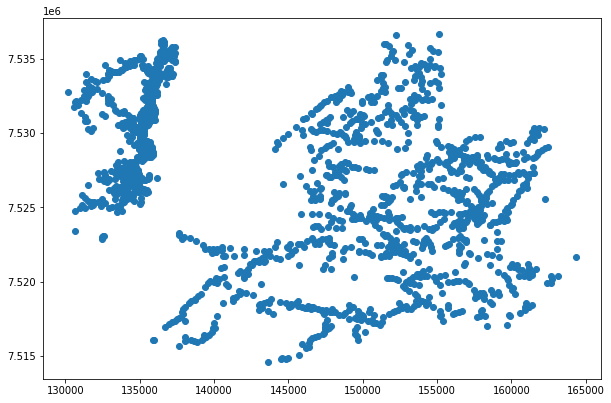

In [ ]:
st = gpd.sjoin(
    join_area_cob[['geometry']], 
    copy_conj[['NOM','geometry']], 
    how='inner', 
    op='within', 
    lsuffix='untrs',
    rsuffix='conj')
st.head()
ax = st.plot(figsize=(10,10))

In [ ]:
# 7 
group_ucbt_untrd_untrs['EUC_DIST_TRUNK'] = -1
group_ucbt_untrd_untrs['EUC_DIST_PRIMARY'] = -1
group_ucbt_untrd_untrs['EUC_DIST_SECONDARY'] = -1

group_ucbt_untrd_untrs['EUC_DIST_UNTRS'] = -1


In [ ]:
centro_urbano = Point(136050.57090952771250159, 7531008.69087591022253036)
group_ucbt_untrd_untrs['EUC_DIST_CENT'] = -1
for i,t in group_ucbt_untrd_untrs.iterrows():
    eud = group_ucbt_untrd_untrs.geometry_untrd[i].distance(centro_urbano)
    group_ucbt_untrd_untrs.EUC_DIST_CENT.loc[i] = eud
    
group_ucbt_untrd_untrs 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX,DIST,PAC_1,PAC_2,PAC_3,FAS_CON_P,FAS_CON_S,FAS_CON_T,SIT_ATIV,TIP_UNID,POS,ATRB_PER,TEN_LIN_SE,CAP_ELO,CAP_CHA,TAP,CONF,POSTO,POT_NOM,PER_FER,PER_TOT,DAT_CON,CTMT,UNI_TR_S,SUB,CONJ,MUN,BANC,TIP_TRAFO,MRT,DESCR,ARE_LOC,geometry_untrd,geometry_untrs,EUC_DIST_TRUNK,EUC_DIST_PRIMARY,EUC_DIST_SECONDARY,EUC_DIST_UNTRS,EUC_DIST_CENT
0,101415715,1,76.55,28.0,97.791667,372.0,6612,76114500752048800ET,76114500752048800BT,,ABC,ABCN,0,AT,38,PD,1,0.38,1H,12,1.0,RA,PT,30.0,150.0,695.0,01/01/1920,27117484,27707534,27335513,15616,3303401,0,T,0,,0,POINT (143363.892 7518580.694),POINT (151650.771 7531499.639),-1,-1,-1,-1,14420.116797
1,103455355,1,8.31,7.0,91.333333,116.0,6612,77452900752550500ET,77452900752550500BT,,C,AN,CN,AT,38,PD,1,0.22,1H,12,1.0,RA,PT,10.0,50.0,245.0,01/01/1920,27117483,27707534,27335513,15616,3303401,0,MT,0,,1,POINT (156545.369 7524131.090),POINT (151650.771 7531499.639),-1,-1,-1,-1,21618.004725
2,105138826,1,16.10,12.0,13.583333,35.0,6612,77725336752398759ET,77725336752398759BT,,B,AN,0,AT,38,PD,1,0.38,05H,12,1.0,RA,PT,5.0,35.0,140.0,01/01/1920,27117483,27707534,27335513,15616,3303401,0,M,0,,0,POINT (159329.456 7522722.774),POINT (151650.771 7531499.639),-1,-1,-1,-1,24709.571305
3,106512676,1,17.24,8.0,84.833333,101.0,6612,77183400752816700ET,77183400752816700BT,,B,BN,0,AT,38,PD,1,0.38,05H,12,1.0,RA,PT,5.0,35.0,140.0,01/01/1920,27117483,27707534,27335513,15616,3303401,0,M,0,,0,POINT (153744.945 7526685.029),POINT (151650.771 7531499.639),-1,-1,-1,-1,18214.964473
4,108015624,1,19.15,9.0,158.166667,180.0,6612,77268557752799305ET,77268557752799305BT,,A,AN,0,AT,38,PD,1,0.23,05H,12,1.0,RA,PT,5.0,35.0,140.0,01/01/1920,27117483,27707534,27335513,15616,3303401,0,M,0,,0,POINT (154603.247 7526545.042),POINT (151650.771 7531499.639),-1,-1,-1,-1,19082.084868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3526,62005694,1,1.06,4.0,26.208333,83.0,6612,75207200752946400ET,75207200752946400BT,,ABC,ABCN,0,AT,38,PD,1,0.38,5H,12,1.0,RA,PT,112.5,390.0,1890.0,01/01/1920,80345445,80345241,27335511,16070,3303401,0,T,0,,1,POINT (133932.738 7527194.744),POINT (135820.103 7532486.422),-1,-1,-1,-1,4362.500497
3527,68553759,1,47.01,76.0,278.571839,14156.0,6612,75229300752853400ET,75229300752853400BT,,ABC,ABCN,0,AT,38,PD,1,0.38,3H,12,1.0,RA,PT,75.0,295.0,1395.0,01/01/1920,80345445,80345241,27335511,16070,3303401,0,T,0,,1,POINT (134190.805 7526273.478),POINT (135820.103 7532486.422),-1,-1,-1,-1,5087.333875
3528,71641214,1,59.29,49.0,216.574830,13831.0,6612,75308400752863500MT,75308400752863500BT,,ABC,ABCN,0,AT,38,PD,1,0.38,0,0,1.0,RA,PT,75.0,295.0,1395.0,01/01/1920,80345446,80345241,27335511,16070,3303401,0,T,0,,1,POINT (134977.834 7526406.003),POINT (135820.103 7532486.422),-1,-1,-1,-1,4726.044503
3529,87219744,1,255.99,154.0,143.215116,9483.0,6612,75311600753145700ET,75311600753145700BT,,ABC,ABCN,0,AT,38,PD,1,0.38,5H,12,1.0,RA,PT,112.5,390.0,1890.0,01/01/1920,80345445,80345241,27335511,16070,3303401,0,T,0,,1,POINT (134897.455 7529229.454),POINT (135820.103 7532486.422),-1,-1,-1,-1,2120.226359


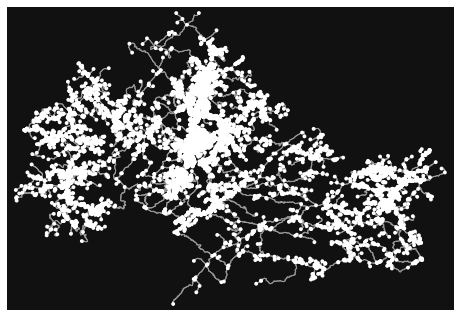

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f50a7e8c080>)

In [ ]:
my_place = 'Nova Friburgo, Rio de Janeiro, Brazil'
G = ox.graph_from_place(my_place)
ox.plot_graph(G)

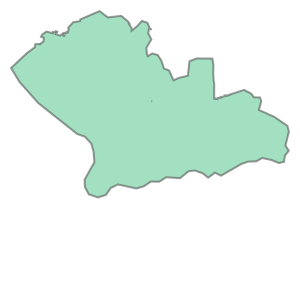

In [ ]:
G.graph['crs']
dist = conj.dissolve(by='DIST')
dist.iloc[0].geometry

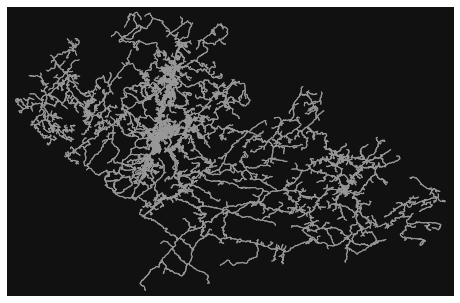

In [ ]:

G_conj = ox.graph_from_polygon(dist.to_crs(epsg=4326).iloc[0].geometry)
fig, ax = ox.plot_graph(G_conj, node_size=0)

In [ ]:
nodes, edges = ox.graph_to_gdfs(G_conj)
edges.crs
edges
edges.to_csv('edges_conj.csv')

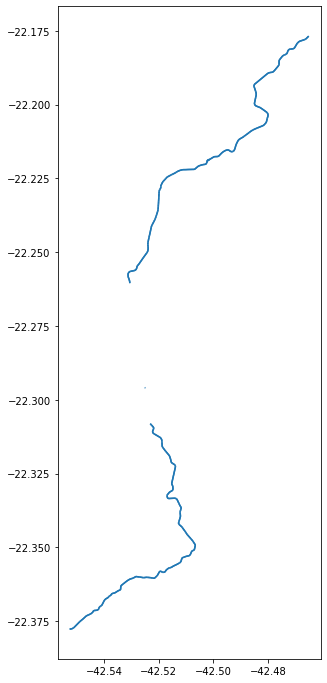

In [ ]:
edges[edges.name.str.contains('Rodovia').fillna(False)].plot(figsize=(12,12))

In [ ]:
mask = (edges.highway.str.contains('trunk').fillna(False) | edges.highway.str.contains('primary').fillna(False))

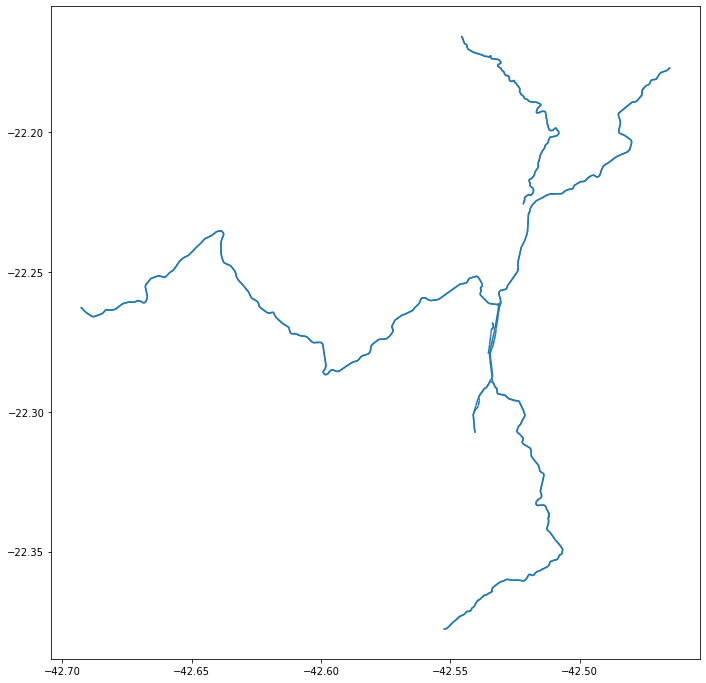

In [ ]:
main_roads = edges[['geometry','length','name', 'ref']][mask]
main_roads.plot(figsize=(12,12))

In [141]:
main_roads['dist'] = 6612
main_roads_comb = main_roads.dissolve(by='dist')
main_roads_comb.to_crs(epsg=31984, inplace= True)
untrd['main_r_dist'] = untrd.distance(main_roads_comb.iloc[0].geometry)
untrd[['main_r_dist','COD_ID']]

,main_r_dist,COD_ID
0,5923.591099,26877970
1,5974.082675,26877971
2,6058.175545,26877972
3,6027.039801,26877973
4,4812.390625,26877974
...,...,...
3874,18591.830258,26876494
3875,20059.940541,26876495
3876,21279.884128,26876496
3877,20580.794807,26876497


In [139]:
group_ucbt_untrd_untrs['EUC_DIST_PRIMARY'] = -1

for i,t in group_ucbt_untrd_untrs.iterrows():
    eud = group_ucbt_untrd_untrs.geometry_untrd[i].distance(main_roads_comb.iloc[0].geometry)    
    group_ucbt_untrd_untrs.EUC_DIST_PRIMARY.loc[i] = eud
    


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0        7174.246302
1       17768.331400
2       20611.624089
3       15155.618112
4       15983.786567
            ...     
3526     2075.178253
3527     2766.387890
3528     2462.301278
3529      226.140706
3530     2786.129867
Name: EUC_DIST_PRIMARY, Length: 3531, dtype: float64

In [147]:

group_ucbt_untrd_untrs[group_ucbt_untrd_untrs.UNI_TR_D=='26877970']

,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX,DIST,PAC_1,PAC_2,PAC_3,FAS_CON_P,FAS_CON_S,FAS_CON_T,SIT_ATIV,TIP_UNID,POS,ATRB_PER,TEN_LIN_SE,CAP_ELO,CAP_CHA,TAP,CONF,POSTO,POT_NOM,PER_FER,PER_TOT,DAT_CON,CTMT,UNI_TR_S,SUB,CONJ,MUN,BANC,TIP_TRAFO,MRT,DESCR,ARE_LOC,geometry_untrd,geometry_untrs,EUC_DIST_TRUNK,EUC_DIST_PRIMARY,EUC_DIST_SECONDARY,EUC_DIST_UNTRS,EUC_DIST_CENT,geometry
1560,26877970,1,14.95,7.0,189.0,274.0,6612,74793200754383100MT,74793200754383100BT,,B,AN,0,AT,38,PD,1,0.22,0,0,1.0,RA,PT,15.0,65.0,330.0,01/01/1920,27117490,27707625,27335509,16069,3303401,0,M,0,,0,POINT (129221.520 7541398.949),POINT (137043.735 7537448.539),-1,5923.591099,-1,-1,12433.559794,POINT (129221.520 7541398.949)


In [ ]:
for i,t in group_ucbt_untrd_untrs.iterrows():
    eud = group_ucbt_untrd_untrs.geometry_untrd[i].distance(centro_urbano)
    group_ucbt_untrd_untrs.EUC_DIST_PRIMARY.loc[i] = eud


In [ ]:
main_roads_comb = main_roads.dissolve(by='dist')
main_roads_comb.to_crs(epsg=31984, inplace= True)

In [ ]:
untrd['main_r_dist'] = untrd.distance(main_roads_comb.iloc[0].geometry)

In [ ]:
untrd.head()

## [Opcional] Generación de variables con arboles de busqueda

8 - Cree variables que indique la cantidad de consumidores en radios de 25, 50 y 100 metros del transformador.

9 - Cree una variable indicando la distancia media de cada fila (cada untrd) a los 5 untrd mas cercanos.

10 - Usando OSMnx descargue los footprints de edificios disponibles, y cree una variable que indique la cantidad de edificios en un radio de 200 metros al transformador.

In [160]:
# Convertimos las coordenas a una matriz
ucbt_loc_array = [x.coords[0] for x in ucbt.geometry]
untrd_loc_array = [x.coords[0] for x in untrd.geometry]
tree = cKDTree(ucbt_loc_array)

In [ ]:
group_ucbt_untrd_untrs['CONS_25M'] = 0
group_ucbt_untrd_untrs['CONS_50M'] = 0
group_ucbt_untrd_untrs['CONS_100M'] = 0

for i,t in group_ucbt_untrd_untrs.iterrows():
  untrd_loc_array = [x.coords[0] for x in [group_ucbt_untrd_untrs.geometry_untrd[i]]]
  radio = 25
  ucbt_25m = tree.query_ball_point(untrd_loc_array, radio)
  radio = 50
  ucbt_50m = tree.query_ball_point(untrd_loc_array, radio)
  radio = 100
  ucbt_100m = tree.query_ball_point(untrd_loc_array, radio)

  group_ucbt_untrd_untrs.CONS_25M.loc[i] = len(ucbt_25m[0])  
  group_ucbt_untrd_untrs.CONS_50M.loc[i] = len(ucbt_50m[0])  
  group_ucbt_untrd_untrs.CONS_100M.loc[i] = len(ucbt_100m[0])  

In [201]:
group_ucbt_untrd_untrs[['UNI_TR_D','CONS_25M','CONS_50M','CONS_100M']].sample(5)

,UNI_TR_D,CONS_25M,CONS_50M,CONS_100M
352,26876579,3,5,12
2285,26878689,1,1,4
622,26876868,0,1,8
2911,26878073,1,5,29
1753,26879761,35,109,318
